In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
import math
import pylab

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [14]:
data = pd.read_csv('./st_features_without_nans_and_y_with_nans.csv')

data = data.dropna(subset=['Y'])

#drop feature ST24TA as it seems to correlate to much with Y
data = data.drop(['ST24TA'], axis = 1)
col_names = np.array(data.keys())

In [16]:
#scoring='accuracy'
#scoring='recall'
#scoring='precision'
#scoring='roc_auc

#1 - NL, 2 - MCI, 3 - AD, drop accroding data based on the task
data_new = data.drop(data[data.Y == 2.0].index)
#data_new = data.copy()
data_new['Y'] = data_new['Y'].replace(3.0,0.0)
#data_new = data.copy()
#data_new['Y'] = data_new['Y'].replace(3.0,2)
#data_new['Y'] = data_new['Y'].replace(2.0,0)

X, y = data_new.drop('Y', axis=1), data_new['Y'].astype(int)

clfs = [KNeighborsClassifier(n_neighbors=10),
        LogisticRegression(solver='liblinear', random_state=42, max_iter=1000),
        RandomForestClassifier(max_depth=3, n_estimators=10, random_state=42)]

Classifiers = ['KNN', 'Logistic', 'Random Forest']
rows = ['mean cross val', 'st dev', 'score on train', 'score on test']

score = pd.DataFrame(np.ones([4,3]), index = rows, columns=Classifiers)

for j, clf in enumerate(clfs):
  approach = clf
  cros = cross_val_score(approach, X, y, scoring='roc_auc', cv=5) 
  cross_validat_score = np.mean(cros)
  st_dev = np.std(cros) 
  score.iloc[0,j] = cross_validat_score
  score.iloc[1,j] = st_dev

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

for i, clf in enumerate(clfs):
  tt = clf.fit(X_train, y_train)
  train = (abs(clf.score(X_train, y_train)))
  test = (abs(clf.score(X_test, y_test)))
  score.iloc[2,i] = train
  score.iloc[3,i] = test

print('Cross-validation scores')
print("roc_auc")
print("NL vs AD")

display(score)

KeyboardInterrupt: 

Roc_auc score for XGBoost: 0.6359865470852019
Roc_auc score for XGBoost (train): 0.7034464108935058


SystemError: <built-in method write of _io.BufferedWriter object at 0x7f3111bf2e00> returned a result with an error set

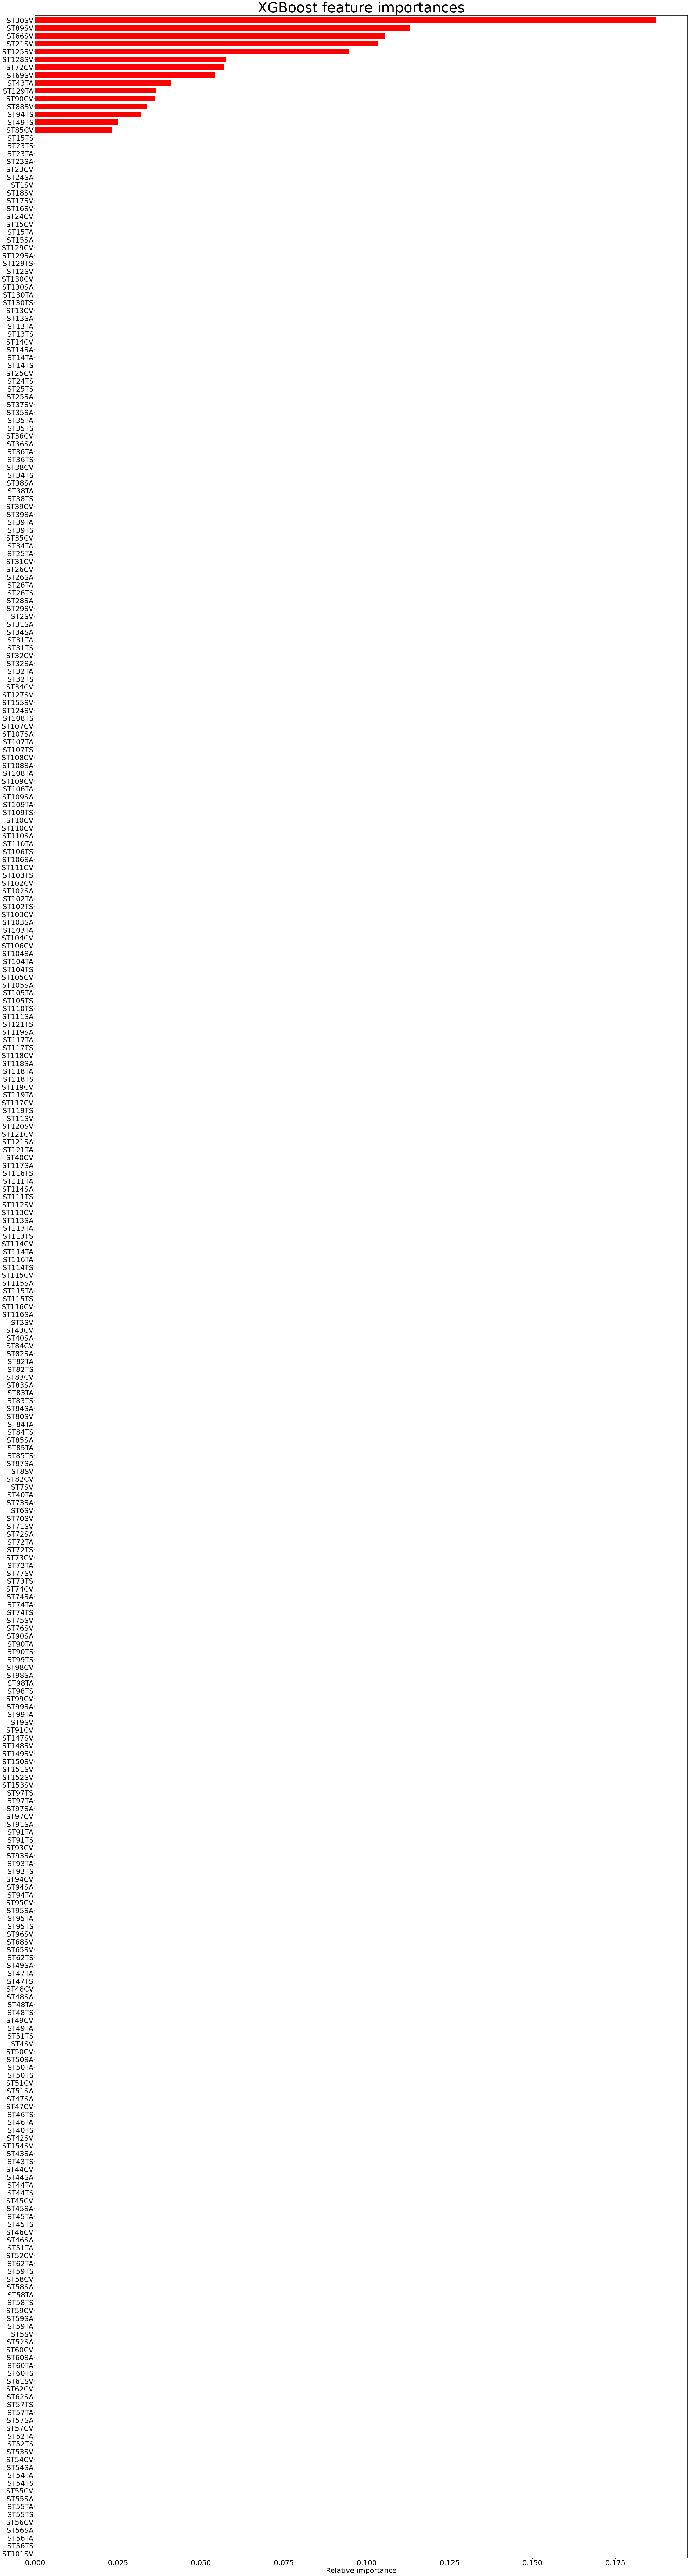

In [19]:
#XGBoost accepts only {0,1} as Y feature
#data_new = data.drop(data[data.Y == 3.0].index)
data_new = data.copy()
data_new['Y'] = data_new['Y'].replace(3.0,2.0)
data_new['Y'] = data_new['Y'].replace(2.0,0.0)

#if train overfits decrease n_estimators, max_depth (check!)
X, y = data_new.drop('Y', axis=1), data_new['Y'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0x0BADBEEF)

xgb = XGBClassifier(use_label_encoder=False, n_estimators=3, max_depth = 3)
xgb.fit(X_train, y_train, eval_metric='error')
xgb_proba = xgb.predict_proba(X_test)
train_pred = xgb.predict_proba(X_train)
print("Roc_auc score for XGBoost:", roc_auc_score(y_test, xgb_proba[:, 1]))
print("Roc_auc score for XGBoost (train):", roc_auc_score(y_train, train_pred[:, 1]))

#ROC CURVE HERE
'''
fpr, tpr, thresholds = roc_curve(y_test, xgb_proba[:, 1])
plt.figure(figsize=(30, 20))
plt.plot(fpr, tpr, label="XGBClassifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.savefig("roc_curve.png")
'''

#FEATURE IMPORTANCES HERE
ids = np.argsort(xgb.feature_importances_)
df = pd.DataFrame({"Xgboost": xgb.feature_importances_[ids]}, index=np.array(col_names[1:])[ids])
df.plot.barh(color='r', width=0.7, figsize=(50,200))
plt.title("XGBoost feature importances", fontsize=60)
plt.xlabel("Relative importance", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.gca().get_legend().remove()
plt.savefig("feature_importances.png")


#GRAPH OF ACCURACY DEPENDENCE ON NUMBER OF MOST IMPORTANT FEATURES USED
'''
last = 200
average_precision_xgb = np.zeros(len(col_names)-1-last)
for i in range(average_precision_xgb.shape[0]):
    selector = SelectFromModel(estimator=xgb, threshold = -np.inf, max_features=len(col_names)-1-last-i, prefit=True)
    x_train_new = selector.transform(X_train)
    x_test_new = selector.transform(X_test)
    y_proba=XGBClassifier(use_label_encoder=False).fit(x_train_new, y_train,eval_metric='error').predict_proba(x_test_new)
    average_precision_xgb[i] = average_precision_score(y_test, y_proba[:, 1])
plt.figure(figsize=(30, 10))
plt.plot(average_precision_xgb)
plt.title("XGBoost")
plt.xlabel("number of features removed")
plt.ylabel("average_precision_score")
plt.grid()
plt.savefig("removing_feature.png")
'''